In [202]:

# Import library

import torch
from torchvision import transforms, models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score
import seaborn as sns
import torchsummary
plt.style.use('ggplot')

In [175]:
import torch, random, numpy as np


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

In [176]:
CLASS = ['real', 'fake']

## Dataloader

In [159]:
class DeepFakeImageDataset(Dataset):
    def __init__(self, data_path, transform):
        super().__init__()
        self.data = []
        self.transform = transform
        for label in os.listdir(data_path):
            label_path = os.path.join(data_path, label)
            for image in os.listdir(label_path):
                image_path = os.path.join(label_path, image)
                self.data.append((image_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path, label = self.data[index]

        original_image = Image.open(image_path).convert("RGB")
        transformed_image = self.transform(original_image)
        
        original_image = np.asarray(original_image)
        y = CLASS.index(label)
        return original_image, transformed_image, torch.tensor(y)

In [14]:
from pathlib import Path
current_path = Path.cwd()
parent_path = (
    current_path.parent.resolve()
)  
print(f"Parent path: {parent_path}")

Parent path: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection


In [146]:
# Define transform for ResNet
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

BATCH_SIZE = 32

def get_device():
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.mps.is_available():
        return 'mps'
    else:
        return 'cpu'

DEVICE = get_device()
DEVICE

'mps'

In [147]:
train_path = os.path.join(parent_path, "data/images/train")
val_path = os.path.join(parent_path, "data/images/val")
train_ds = DeepFakeImageDataset(train_path, transform=transform)
val_ds = DeepFakeImageDataset(val_path, transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)

## Resnet18 Transfer Learning

In [ ]:

class DeepFakeResNet(nn.Module):
    def __init__(self, num_classes = 2, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = models.resnet18(weights="IMAGENET1K_V1")
        num_ftrs = self.model.fc.in_features
        params = list(self.model.parameters())
        for param in params:
            param.requires_grad = False
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, X):
        return self.model(X)

In [161]:
def get_labels(logits):
    return torch.argmax(nn.Softmax(dim = -1)(logits), dim = 1).cpu().detach().flatten().tolist()

In [149]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [170]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    loop = tqdm(dataloader, desc="Training")

    for _, images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)

        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples

    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    all_labels = []
    all_preds = []
    all_probs_real = []

    with torch.inference_mode():
        for _, images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1)

            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs_real.extend(probs[:, 1].cpu().numpy())

    avg_loss = running_loss / total_samples
    avg_acc = correct_predictions / total_samples

    f1 = f1_score(all_labels, all_preds, average="binary")

    try:
        auc = roc_auc_score(all_labels, all_probs_real)
    except ValueError:
        auc = 0.0

    return avg_loss, avg_acc, f1, auc

## Train head only first

In [226]:
TASK_NAME = 'image_classification'
LR = 1e-3
EPOCHS = 10
MODEL_NAME = "Resnet18"

In [225]:
model = DeepFakeResNet()

In [217]:
torchsummary.summary(model, (3, 224, 224), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]          36,864
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
       BasicBlock-11           [32, 64, 56, 56]               0
           Conv2d-12           [32, 64, 56, 56]          36,864
      BatchNorm2d-13           [32, 64, 56, 56]             128
             ReLU-14           [32, 64,

In [227]:
model = model.to(device=DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr = LR)
criterion = nn.CrossEntropyLoss()

In [228]:
history = {
    "model_name": MODEL_NAME,
    "train_losses": [],
    "val_losses": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "val_f1": [],
    "val_auc": [],
    "best_accuracy": 0.0,
    "best_epoch": 0,
    "MODEL_SAVED_PATH": "",
}

best_acc = 0.0

In [229]:
import json
def save_experiment_json(history, filename):
    """@
    Saves the experiment history to a JSON file.
    """
    with open(filename, "w") as f:
        json.dump(history, f, indent=4)
    print(f"History saved to {filename}")


def save_checkpoint(model, optimizer, filename="checkpoint.pth"):
    checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    torch.save(checkpoint, filename)
    print("Checkpoint saved:", filename)

In [230]:

MODEL_SAVED_PATH = os.path.join(
    parent_path, f"model_checkpoints/resnet18_{TASK_NAME}.pth"
)

print(f"Training configuration: LR = {LR}, EPOCHS = {EPOCHS}")

for epoch in range(EPOCHS):
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )

    # Evaluate
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{EPOCHS}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )
    # Record metrics
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)

    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint(model, optimizer, MODEL_SAVED_PATH)

        # Update best stats
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = MODEL_SAVED_PATH

    print(
        f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n"
    )

Training configuration: LR = 0.001, EPOCHS = 10


Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.06it/s]


[1/10] train_acc: 0.5797 - train_loss: 0.6830 - valid_acc: 0.5885 - valid_loss: 0.6773
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/resnet18_image_classification.pth
	- [current best] epoch: 1 - acc: 0.5885



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.21it/s]


[2/10] train_acc: 0.6080 - train_loss: 0.6629 - valid_acc: 0.6112 - valid_loss: 0.6548
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/resnet18_image_classification.pth
	- [current best] epoch: 2 - acc: 0.6112



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.14it/s]


[3/10] train_acc: 0.6112 - train_loss: 0.6595 - valid_acc: 0.5990 - valid_loss: 0.6710
	- [current best] epoch: 2 - acc: 0.6112



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.05it/s]


[4/10] train_acc: 0.6150 - train_loss: 0.6577 - valid_acc: 0.6028 - valid_loss: 0.6636
	- [current best] epoch: 2 - acc: 0.6112



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.21it/s]


[5/10] train_acc: 0.6180 - train_loss: 0.6561 - valid_acc: 0.6115 - valid_loss: 0.6600
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/resnet18_image_classification.pth
	- [current best] epoch: 5 - acc: 0.6115



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.22it/s]


[6/10] train_acc: 0.6180 - train_loss: 0.6562 - valid_acc: 0.6105 - valid_loss: 0.6655
	- [current best] epoch: 5 - acc: 0.6115



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.20it/s]


[7/10] train_acc: 0.6193 - train_loss: 0.6529 - valid_acc: 0.5863 - valid_loss: 0.7058
	- [current best] epoch: 5 - acc: 0.6115



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.22it/s]


[8/10] train_acc: 0.6176 - train_loss: 0.6565 - valid_acc: 0.5835 - valid_loss: 0.6996
	- [current best] epoch: 5 - acc: 0.6115



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.27it/s]


[9/10] train_acc: 0.6248 - train_loss: 0.6514 - valid_acc: 0.6088 - valid_loss: 0.6611
	- [current best] epoch: 5 - acc: 0.6115



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.24it/s]

[10/10] train_acc: 0.6274 - train_loss: 0.6504 - valid_acc: 0.6098 - valid_loss: 0.6612
	- [current best] epoch: 5 - acc: 0.6115



## Performance evaludation

In [302]:
def plot_history(history, title, save_path, start_finetuned_epoch=None):
    epochs = range(1, len(history["train_losses"]) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    plt.suptitle(title)

    ax[0].plot(
        epochs,
        history["train_losses"],
        label="training loss",
        marker="*",
        color="green",
    )
    ax[0].plot(
        epochs, history["val_losses"], label="validation loss", marker="s", color="blue"
    )
    ax[0].set_title("Loss Curve")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    if start_finetuned_epoch is not None:
        ax[0].axvline(
            x=start_finetuned_epoch,
            color="red",
            linestyle="--",
            label="Start Fine-Tuning",
        )
    ax[0].legend()
    ax[0].grid(True, linestyle="--", alpha=0.7)

    ax[1].plot(
        epochs,
        history["train_accuracy"],
        label="training accuracy",
        marker="*",
        color="green",
    )
    ax[1].plot(
        epochs,
        history["val_accuracy"],
        label="validation accuracy",
        marker="s",
        color="blue",
    )
    ax[1].set_title("Accuracy Curve")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    if start_finetuned_epoch is not None:
        ax[1].axvline(
            x=start_finetuned_epoch,
            color="red",
            linestyle="--",
            label="Start Fine-Tuning",
        )
    ax[1].grid(True, linestyle="--", alpha=0.7)

    plt.savefig(save_path)
    plt.tight_layout()
    plt.show()

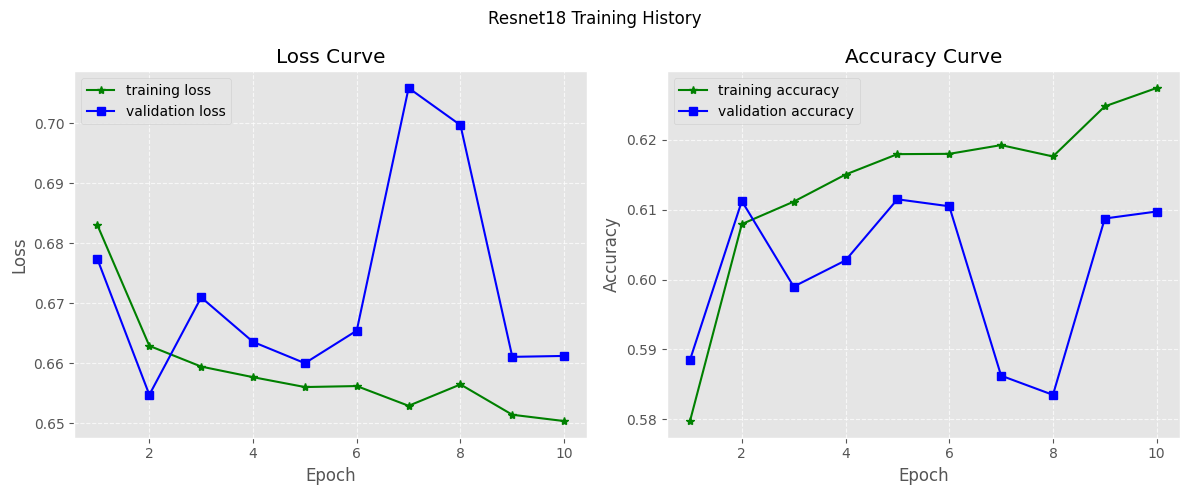

In [ ]:
# Plot model Performance
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plot_history(history, "Resnet18 Training History")

torch.Size([32, 256, 256, 3])


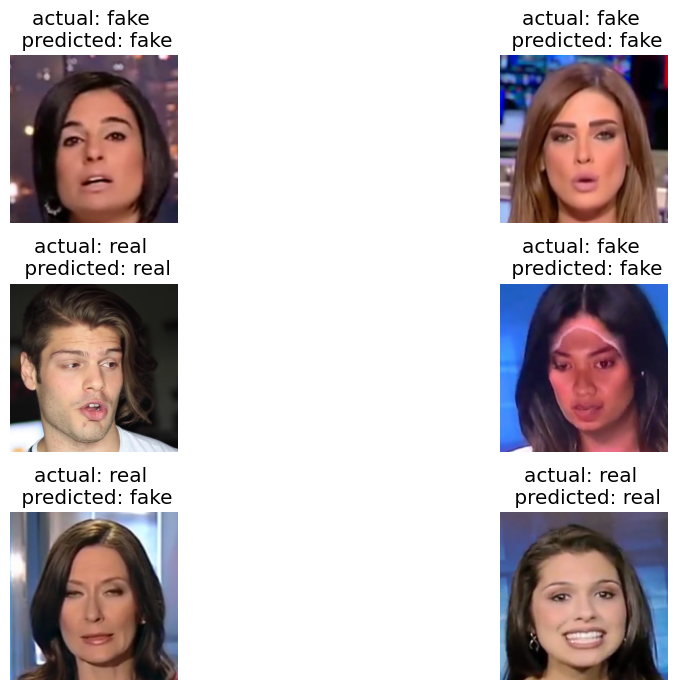

In [274]:
import matplotlib.pyplot as plt
def visualize_model_prediction(model, dataloader,  num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 7))

    with torch.no_grad():
        for i, (originals, inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            print(originals.shape)
            outputs = model(inputs)
            preds = get_labels(outputs)

            # Get random index
            random_indices = np.random.choice(np.arange(inputs.size()[0]), size = num_images, replace=False)

            for j in random_indices:
                images_so_far += 1
                plt.subplot(num_images // 2, 2, images_so_far)
                plt.axis('off')
                plt.title(f"actual: {CLASS[labels[j].item()]} \n predicted: {CLASS[preds[j]]}")
                plt.tight_layout()
                plt.imshow(originals.cpu().data[j])

                if images_so_far == num_images:
                    return
visualize_model_prediction(model, val_loader, num_images=6)

In [233]:
from sklearn.metrics import (
    f1_score,
    recall_score,
    ConfusionMatrixDisplay,
    confusion_matrix,
    classification_report,
)

In [234]:

def get_target_pred(model, data_loader):
    model.eval()
    targets, preds = [], []
    with torch.inference_mode():
        for _, inputs, labels in tqdm(data_loader, desc="Eval"):
            inputs = inputs.to(device=DEVICE)
            labels = labels.to(device=DEVICE)
            logits = model(inputs)
            targets.extend(labels.cpu().detach().tolist())
            preds.extend(get_labels(logits))
    return targets, preds 

targets, preds = get_target_pred(model, val_loader)

Eval: 100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


In [235]:
print(classification_report(targets, preds))

              precision    recall  f1-score   support

           0       0.63      0.54      0.58      2000
           1       0.60      0.68      0.63      2000

    accuracy                           0.61      4000
   macro avg       0.61      0.61      0.61      4000
weighted avg       0.61      0.61      0.61      4000



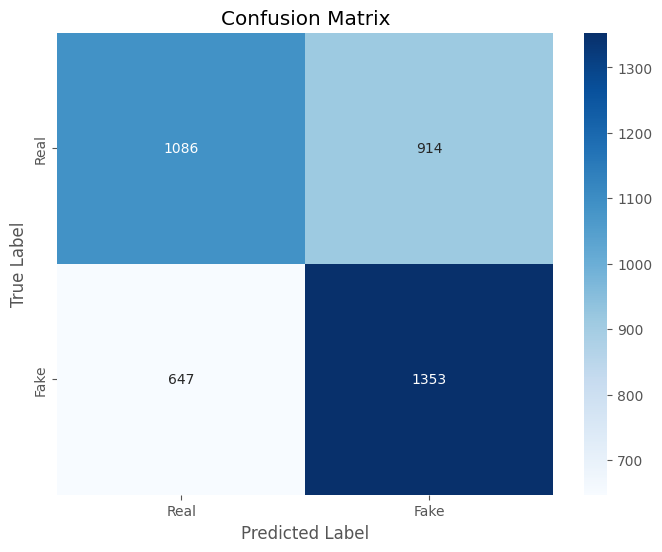

In [ ]:
def plot_confusion_matrix_heatmap(y_true, y_pred, title, class_names=["Real", "Fake"]):
    """
    Generates and plots a confusion matrix heatmap.
    """
    import matplotlib.pyplot as plt

    plt.style.use("ggplot")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    img_save = f"../resultssssss/{MODEL_NAME}_{TASK_NAME}_cfm.png"
    plt.savefig(img_save)
    plt.show()


plot_confusion_matrix_heatmap(targets, preds,f"Confusion Matrix", class_names=["Real", "Fake"])

In [276]:
# Load the model again
checkpoint = torch.load(MODEL_SAVED_PATH)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [ ]:
# Save history
json_path = os.path.join(
    parent_path, f"results/{MODEL_NAME}_{TASK_NAME}_history.json")
save_experiment_json(history, json_path)

History saved to /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/result/Resnet18_image_classification_history.json


## Finetune the model

In [251]:
model

DeepFakeResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

As the dataset size is around 22,000 images, we first fine-tune the last two blocks of the architecture above which are `layer3` and `layer4`

Each layer will be updated with different learning rate so that we can prevent model from catastrophic forgetting

In [ ]:



def unfreeze_model(model, layer_names):
    for layer_name in layer_names:
        layer = getattr(model.model, layer_name)
        for param in layer.parameters():    
            param.requires_grad = True

unfreezed_layers = ['layer3','layer4']
unfreeze_model(model, unfreezed_layers)
torchsummary.summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
model = model.to(DEVICE)
new_optimizer = torch.optim.Adam([
    {"params": model.model.fc.parameters(), "lr": 1e-4},
    {"params": model.model.layer4.parameters(), "lr": 1e-4},
    {"params": model.model.layer3.parameters(), "lr": 1e-5},
])
criterion = nn.CrossEntropyLoss()

In [ ]:
NUM_FINETUNED_EPOCHS = 10

model_saved_path = os.path.join(
    parent_path, f"model_checkpoints/{MODEL_NAME}_finetuned_{TASK_NAME}.pth"
)

TOTAL_EPOCHS = EPOCHS + NUM_FINETUNED_EPOCHS
print(f"START FINETUNING {MODEL_NAME}")
for epoch in range(EPOCHS, TOTAL_EPOCHS, 1):
    # Traina
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, new_optimizer, DEVICE
    )

    # Evaluate
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{TOTAL_EPOCHS}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )
    # Record metrics
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)

    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint(model, new_optimizer, model_saved_path)

        # Update best stats
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = model_saved_path

    print(
        f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n"
    )

START FINETUNING Resnet18


Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.71it/s]


[11/20] train_acc: 0.7635 - train_loss: 0.4866 - valid_acc: 0.7788 - valid_loss: 0.5185
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Resnet18_finetuned_image_classification.pth
	- [current best] epoch: 11 - acc: 0.7788



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.07it/s]


[12/20] train_acc: 0.8923 - train_loss: 0.2567 - valid_acc: 0.7570 - valid_loss: 0.7772
	- [current best] epoch: 11 - acc: 0.7788



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.04it/s]


[13/20] train_acc: 0.9375 - train_loss: 0.1559 - valid_acc: 0.8005 - valid_loss: 0.6722
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Resnet18_finetuned_image_classification.pth
	- [current best] epoch: 13 - acc: 0.8005



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.06it/s]


[14/20] train_acc: 0.9609 - train_loss: 0.1023 - valid_acc: 0.8040 - valid_loss: 0.7797
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Resnet18_finetuned_image_classification.pth
	- [current best] epoch: 14 - acc: 0.8040



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.07it/s]


[15/20] train_acc: 0.9678 - train_loss: 0.0871 - valid_acc: 0.8065 - valid_loss: 0.7158
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Resnet18_finetuned_image_classification.pth
	- [current best] epoch: 15 - acc: 0.8065



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.16it/s]


[16/20] train_acc: 0.9764 - train_loss: 0.0644 - valid_acc: 0.8115 - valid_loss: 0.8493
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Resnet18_finetuned_image_classification.pth
	- [current best] epoch: 16 - acc: 0.8115



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  6.99it/s]


[17/20] train_acc: 0.9793 - train_loss: 0.0553 - valid_acc: 0.7913 - valid_loss: 1.0807
	- [current best] epoch: 16 - acc: 0.8115



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.04it/s]


[18/20] train_acc: 0.9835 - train_loss: 0.0443 - valid_acc: 0.8195 - valid_loss: 0.8772
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Resnet18_finetuned_image_classification.pth
	- [current best] epoch: 18 - acc: 0.8195



Evaluating: 100%|██████████| 125/125 [00:23<00:00,  5.28it/s]


[19/20] train_acc: 0.9856 - train_loss: 0.0398 - valid_acc: 0.8230 - valid_loss: 0.9279
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Resnet18_finetuned_image_classification.pth
	- [current best] epoch: 19 - acc: 0.8230



Evaluating: 100%|██████████| 125/125 [00:24<00:00,  5.20it/s]

[20/20] train_acc: 0.9869 - train_loss: 0.0359 - valid_acc: 0.8243 - valid_loss: 0.9881
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Resnet18_finetuned_image_classification.pth
	- [current best] epoch: 20 - acc: 0.8243



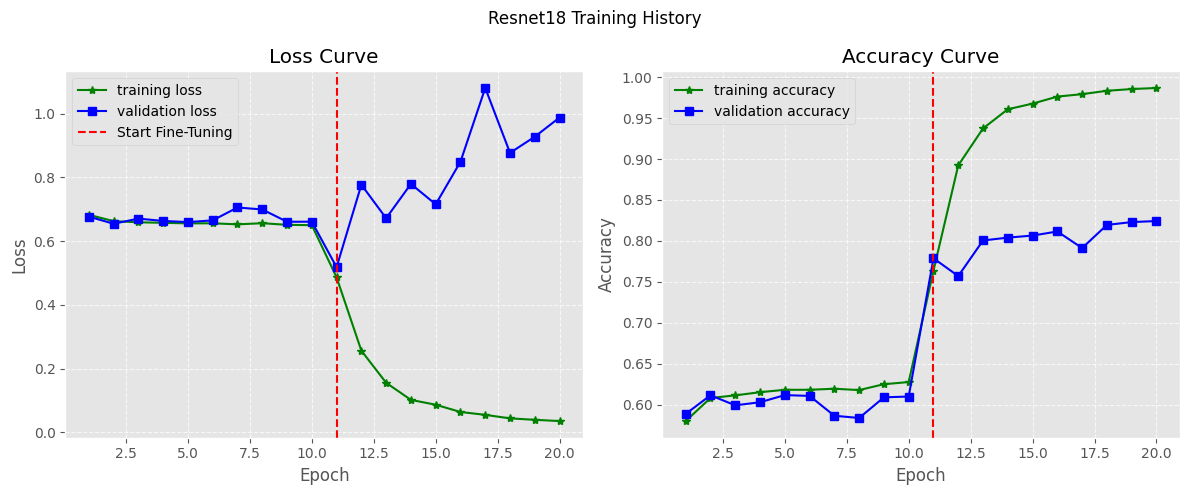

In [270]:
plot_history(history, f"{MODEL_NAME} Training History", start_finetuned_epoch=EPOCHS + 1)

In [289]:
# Load the model again
checkpoint = torch.load(model_saved_path)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

torch.Size([32, 256, 256, 3])


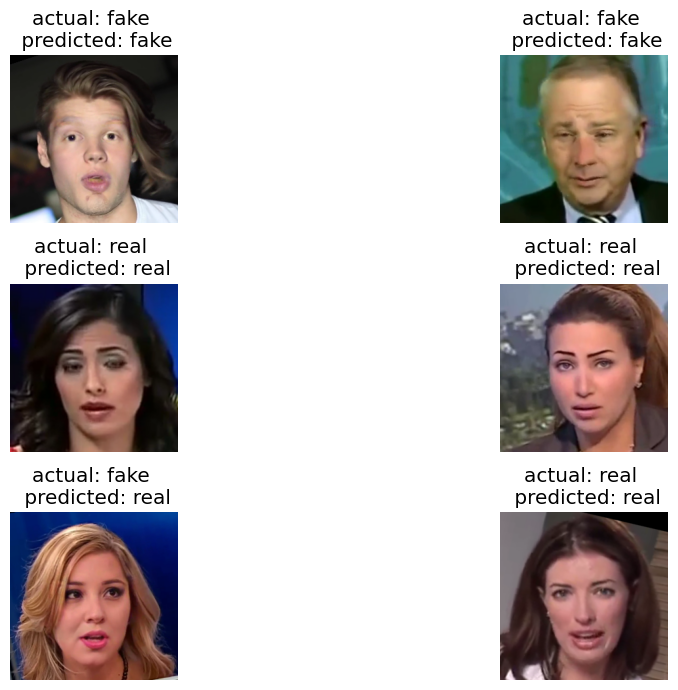

In [290]:
visualize_model_prediction(model, val_loader, num_images=6)

In [291]:
def get_target_pred(model, data_loader):
    model.eval()
    targets, preds = [], []
    with torch.inference_mode():
        for _, inputs, labels in tqdm(data_loader, desc="Eval"):
            inputs = inputs.to(device=DEVICE)
            labels = labels.to(device=DEVICE)
            logits = model(inputs)
            targets.extend(labels.cpu().detach().tolist())
            preds.extend(get_labels(logits))
    return targets, preds


targets, preds = get_target_pred(model, val_loader)

Eval: 100%|██████████| 125/125 [00:23<00:00,  5.34it/s]


In [292]:
print(classification_report(targets, preds))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      2000
           1       0.81      0.85      0.83      2000

    accuracy                           0.82      4000
   macro avg       0.83      0.82      0.82      4000
weighted avg       0.83      0.82      0.82      4000



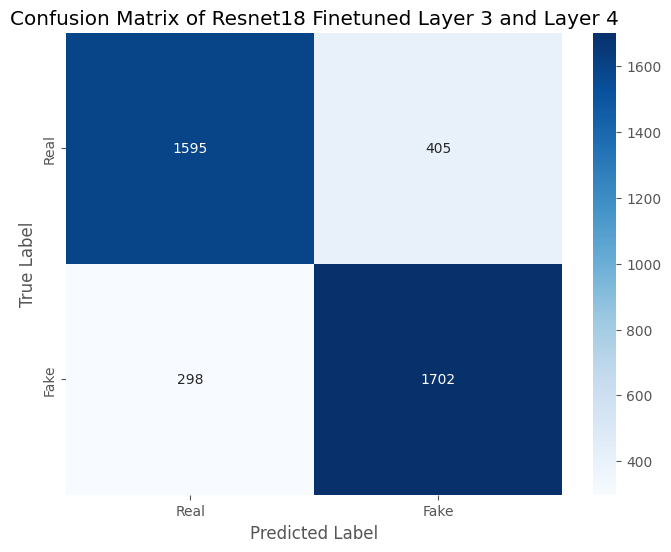

In [ ]:
def plot_confusion_matrix_heatmap(y_true, y_pred, title, save_path, class_names=["Real", "Fake"]):
    """
    Generates and plots a confusion matrix heatmap.
    """
    import matplotlib.pyplot as plt

    plt.style.use("ggplot")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.savefig(save_path)
    plt.show()

save_path = f"../results/{MODEL_NAME}_finetuned_layer3_layer4_{TASK_NAME}_cfm.png"
plot_confusion_matrix_heatmap(
    targets,
    preds,
    f"Confusion Matrix of {MODEL_NAME} Finetuned Layer 3 and Layer 4",
    save_path,
    class_names=["Real", "Fake"],
)

In [ ]:
json_path = os.path.join(parent_path, f"results/{MODEL_NAME}_finetuned_layer3_layer4_{TASK_NAME}_history.json")
save_experiment_json(history, json_path)

History saved to /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/result/Resnet18_finetuned_layer3_layer4_image_classification_history.json


## Unfreeze all layers

In [ ]:
# Load old history before fine-tuning
path = f"../results/{MODEL_NAME}_{TASK_NAME}_history.json"
with open(path, "r") as f:
    history = json.load(f)

In [294]:
# Load old model before fine-tuning
checkpoint = torch.load(MODEL_SAVED_PATH)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [298]:
torchsummary.summary(model.to('cpu'), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [299]:
for param in model.parameters():
    param.requires_grad = True

NEW_LR = 1e-5  # Small updates
model = model.to(DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=NEW_LR)
criterion = nn.CrossEntropyLoss()

In [300]:
NUM_FINETUNED_EPOCHS = 10

model_saved_path = os.path.join(
    parent_path, f"model_checkpoints/{MODEL_NAME}_finetuned_all_layers_{TASK_NAME}.pth"
)

TOTAL_EPOCHS = EPOCHS + NUM_FINETUNED_EPOCHS
print(f"START FINETUNING {MODEL_NAME} AT EPOCH = {EPOCHS + 1}")
for epoch in range(EPOCHS, TOTAL_EPOCHS, 1):
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )

    # Evaluate
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{TOTAL_EPOCHS}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )
    # Record metrics
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)

    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint(model, optimizer, model_saved_path)

        # Update best stats
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = model_saved_path

    print(
        f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n"
    )

START FINETUNING Resnet18 AT EPOCH = 11


Evaluating: 100%|██████████| 125/125 [00:23<00:00,  5.34it/s]


[11/20] train_acc: 0.7811 - train_loss: 0.4660 - valid_acc: 0.7812 - valid_loss: 0.4836
	- [current best] epoch: 5 - acc: 0.6115



Evaluating: 100%|██████████| 125/125 [00:23<00:00,  5.34it/s]


[12/20] train_acc: 0.8957 - train_loss: 0.2641 - valid_acc: 0.7870 - valid_loss: 0.5403
	- [current best] epoch: 5 - acc: 0.6115



Evaluating: 100%|██████████| 125/125 [00:23<00:00,  5.29it/s]


[13/20] train_acc: 0.9440 - train_loss: 0.1554 - valid_acc: 0.8257 - valid_loss: 0.4920
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Resnet18_finetuned_all_layers_image_classification.pth
	- [current best] epoch: 13 - acc: 0.8257



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.33it/s]


[14/20] train_acc: 0.9672 - train_loss: 0.0961 - valid_acc: 0.8045 - valid_loss: 0.6318
	- [current best] epoch: 13 - acc: 0.8257



Evaluating: 100%|██████████| 125/125 [00:16<00:00,  7.39it/s]


[15/20] train_acc: 0.9812 - train_loss: 0.0594 - valid_acc: 0.8165 - valid_loss: 0.6644
	- [current best] epoch: 13 - acc: 0.8257



Evaluating: 100%|██████████| 125/125 [00:16<00:00,  7.40it/s]


[16/20] train_acc: 0.9864 - train_loss: 0.0444 - valid_acc: 0.8270 - valid_loss: 0.6962
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Resnet18_finetuned_all_layers_image_classification.pth
	- [current best] epoch: 16 - acc: 0.8270



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.27it/s]


[17/20] train_acc: 0.9900 - train_loss: 0.0320 - valid_acc: 0.8363 - valid_loss: 0.6359
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Resnet18_finetuned_all_layers_image_classification.pth
	- [current best] epoch: 17 - acc: 0.8363



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.43it/s]


[18/20] train_acc: 0.9925 - train_loss: 0.0248 - valid_acc: 0.8403 - valid_loss: 0.6729
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Resnet18_finetuned_all_layers_image_classification.pth
	- [current best] epoch: 18 - acc: 0.8403



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.41it/s]


[19/20] train_acc: 0.9920 - train_loss: 0.0235 - valid_acc: 0.8160 - valid_loss: 0.8885
	- [current best] epoch: 18 - acc: 0.8403



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.36it/s]

[20/20] train_acc: 0.9926 - train_loss: 0.0218 - valid_acc: 0.8390 - valid_loss: 0.8049
	- [current best] epoch: 18 - acc: 0.8403



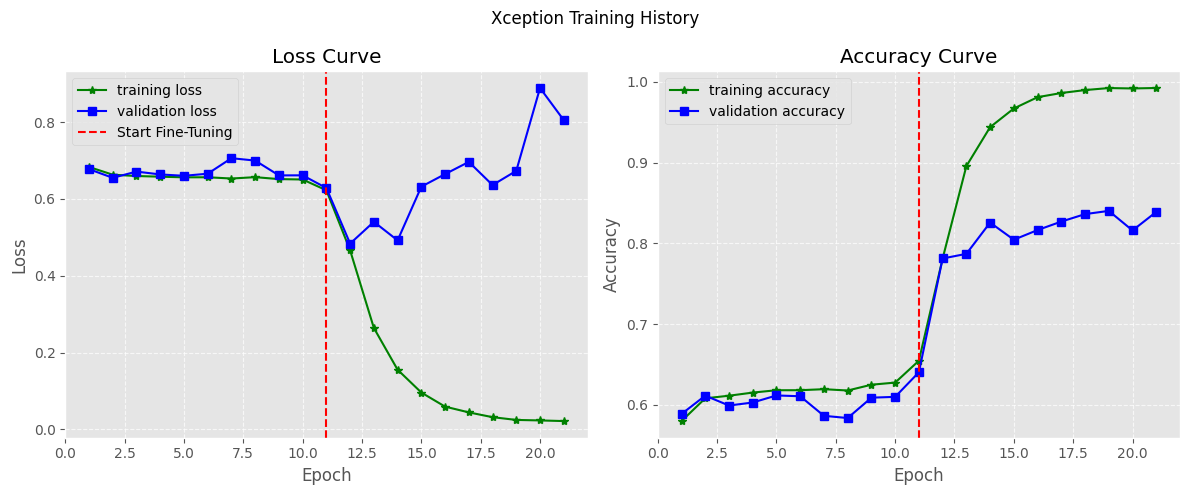

In [ ]:
save_path = f"{parent_path}/results/{MODEL_NAME}_finetuned_all_{TASK_NAME}.png"
plot_history(
    history,
    "Xception Training History",
    save_path=save_path,
    start_finetuned_epoch=EPOCHS + 1,
)

## Train the entire model with data augmentation

In [370]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# Define the training augmentation pipeline
train_transforms = A.Compose(
    [
        # --- SPATIAL AUGMENTATION (Standard) ---
        A.HorizontalFlip(p=0.5),  # DeepFakes should be detectable even if flipped
        # # Rotate slightly. Don't rotate too much or you lose the "upright face" context
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        # # 2. Add Noise: Destroys specific camera/generator noise fingerprints
        A.OneOf(
            [
                A.GaussNoise(p=0.5),
                A.ISONoise(color_shift=(0.01, 0.02), intensity=(0.4, 0.5), p=0.5),
            ],
            p=0.5,
        ),
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

# Validation should NOT have noise/dropout, only Resize/Normalize
val_transforms = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6399999].


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

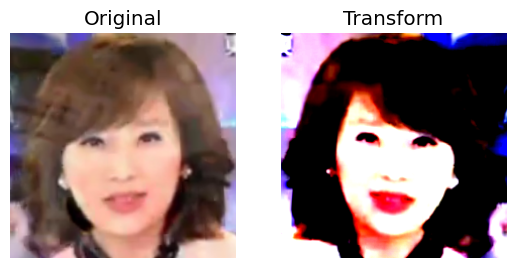

In [369]:
image_path = "/Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/data/images/val/fake/fake_001995.png"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Transform")
plt.imshow(train_transforms(image=image)["image"].permute(1, 2, 0))
plt.axis("off")